# Analysis - Parcel Value

Looking into the results of [geodata fusion](Geodata%20Fusion.ipynb) work to quantify the impacts of sex offender residence restrictions.

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

In [2]:
# pip install GeoAlchemy2

In [3]:
# a few more imports specfic to the database process
# import geoalchemy2 # this is only needed if we're going to load data back into PostGIS
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


### Establish database connection

In [4]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [5]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)


In [6]:
# establish cursor and read the existing tables
cursor = conn.cursor()

cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables = [i[0] for i in cursor.fetchall()] # A list() of tables.
tables.sort()
tables


['country_borders',
 'gadm_admin_borders',
 'geonames_feature',
 'msorfailedgeocoding',
 'msorfailedgeocodingv2',
 'spatial_ref_sys',
 'stlchildcare',
 'stlnonrestrictedresidential',
 'stlnonrestrictedresparcels',
 'stlpubschools',
 'stlpvtschools',
 'stlresparcels',
 'stlrestrictedflat',
 'stlrestrictedresparcels',
 'stlsexoffenders',
 'stlzoning']

#### Pull residental parcel data from PostGIS database

In [7]:
# create sql statement and pull from db into a geopandas dataframe
# we only need residential data here, so specify that during the SELECT
sql = "SELECT handle, asdtotal, ressaleprice, nbrofbldgsres, zoning, geometry as geom FROM stlresparcels;"
gdf_parcels = gpd.read_postgis(sql, conn)
# gpd_childcare = gpd_childcare.drop(columns='geometry') # drop the duplicate geometry column
gdf_parcels.head()

,handle,asdtotal,ressaleprice,nbrofbldgsres,zoning,geom
0,10099008011,48000,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
1,10099008011,249700,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
2,10099008011,278400,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
3,10099008011,161900,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
4,10099008011,169800,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."


In [8]:
gdf_parcels.shape

(98668, 6)

#### Pull nonrestricted area geometry from PostGIS database

In [9]:
# create sql statement and pull from db into a geopandas dataframe
# query the table and read data into a geodf 
sql = "select * from stlnonrestrictedresparcels;"
gdf_res_remain = gpd.read_postgis(sql, conn)
gdf_res_remain.head()


,handle,asdtotal,nbrofbldgsres,geom,savedindex
0,10099008011,48000,1,"POLYGON ((-90.18822 38.62792, -90.18828 38.627...",0
1,10099008011,249700,1,"POLYGON ((-90.18822 38.62792, -90.18828 38.627...",1
2,10099008011,278400,1,"POLYGON ((-90.18822 38.62792, -90.18828 38.627...",2
3,10099008011,161900,1,"POLYGON ((-90.18822 38.62792, -90.18828 38.627...",3
4,10099008011,169800,1,"POLYGON ((-90.18822 38.62792, -90.18828 38.627...",4


In [10]:
gdf_res_remain.shape

(48542, 5)

#### Pull \*restricted\* area geometry from PostGIS database

In [11]:
# create sql statement and pull from db into a geopandas dataframe
# query the table and read data into a geodf 
sql = "select * from stlrestrictedresparcels;"
gdf_res_restricted = gpd.read_postgis(sql, conn)
gdf_res_restricted.head()


,handle,asdtotal,nbrofbldgsres,geom,savedindex
0,10173008031,51620,1,"POLYGON ((-90.19245 38.63159, -90.19264 38.630...",121
1,10173008031,33590,1,"POLYGON ((-90.19245 38.63159, -90.19264 38.630...",122
2,10173008031,30530,1,"POLYGON ((-90.19245 38.63159, -90.19264 38.630...",123
3,10173008031,44690,1,"POLYGON ((-90.19245 38.63159, -90.19264 38.630...",124
4,10173008031,36800,1,"POLYGON ((-90.19245 38.63159, -90.19264 38.630...",125


In [12]:
gdf_res_restricted.shape

(50126, 5)

### Work up some value-based summary info

In [13]:
# generate summary info from each dataset
asdtotal_all = gdf_parcels['asdtotal'].describe()
asdtotal_remain = gdf_res_remain['asdtotal'].describe()
asdtotal_restr = gdf_res_restricted['asdtotal'].describe()


In [14]:
asd_summary = pd.merge(asdtotal_all, asdtotal_remain, right_index = True, left_index = True)
asd_summary = pd.merge(asd_summary, asdtotal_restr, right_index = True, left_index = True)

asd_summary.columns = ['all_parcels','unrestricted_parcels','restricted_parcels']

asd_summary_count = asd_summary[:1]

asd_summary = asd_summary.drop(asd_summary.index[[0]])

asd_summary.style.format({
    'all_parcels': "${:,.0f}".format, 
    'unrestricted_parcels': "${:,.0f}".format, 
    'restricted_parcels': "${:,.0f}".format
})

,all_parcels,unrestricted_parcels,restricted_parcels
mean,"$21,896","$23,874","$19,981"
std,"$28,886","$31,528","$25,930"
min,$0,$0,$0
25%,"$4,510","$5,880","$3,690"
50%,"$16,970","$19,575","$13,490"
75%,"$30,860","$31,890","$29,620"
max,"$3,761,500","$3,761,500","$1,416,100"


In [15]:
asd_summary_count

,all_parcels,unrestricted_parcels,restricted_parcels
count,98668.0,48542.0,50126.0


### Generate box plot

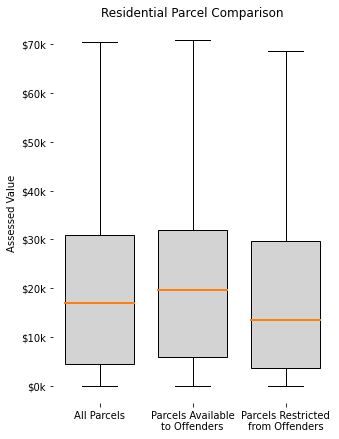

In [16]:
from matplotlib.ticker import FuncFormatter

box_plot_data=[gdf_parcels['asdtotal'],gdf_res_remain['asdtotal'],gdf_res_restricted['asdtotal']]

fig, ax = plt.subplots(figsize=(5,7), facecolor='white')


def thousands(x, pos):
    'The two args are the value and tick position'
    return '$%1.fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

ax.yaxis.set_major_formatter(formatter)


plt.boxplot(box_plot_data, patch_artist=True, 
                labels=['All Parcels','Parcels Available\nto Offenders','Parcels Restricted\nfrom Offenders'], 
                showfliers=False, widths = 0.75, boxprops=dict(facecolor='lightgrey'), medianprops=dict(linewidth=2))
plt.gca().set(title='Residential Parcel Comparison', ylabel='Assessed Value')

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

plt.show()


In [17]:
gdf_parcels.shape[0]

98668

In [18]:
sorted(gdf_parcels.asdtotal, reverse=True)[:25]

[3761500,
 1416100,
 1079410,
 1049300,
 955680,
 921140,
 907190,
 889260,
 798010,
 710450,
 704940,
 703000,
 665000,
 651030,
 644380,
 608000,
 573750,
 549600,
 535150,
 532870,
 501600,
 500730,
 495600,
 486210,
 482010]

#### Hypothesis testing

H0 : Average value of parcels available to offenders > average value of all parcels

H1 : Average value of parcels available to offenders <= average value of all parcels


In [19]:
import numpy as np
import scipy.stats as stats


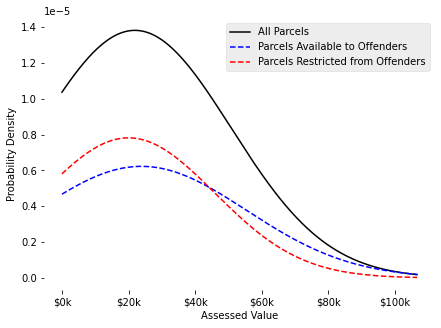

In [101]:
# Hypothesis testing analysis and results
# ---------------------------------------

# First, plot the distributions of each partition vs. the whole data set 
# so we can get an idea of what we're working with.
# Then, generate z-scores and p-values.
# Use an alpha (𝛼) threshold of 0.05, i.e. a 95% confidence interval

fig, ax = plt.subplots(figsize=(7,5), facecolor='white')

ax.xaxis.set_major_formatter(formatter)

# cut the plotting range at so we can actually see the plots (else a few outliers pull it way to the right)
# x = np.arange(0,200000,1)
# set the x-axis limit based on the 99th percentile value of the overall parcel dataset
x = np.arange(0,gdf_parcels['asdtotal'].quantile(0.99),1)

# stats for full data set
mu = gdf_parcels.asdtotal.mean()
sigma = gdf_parcels.asdtotal.std()

# Plot a normal distribution: "Probability Density Function"
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x,y,'k-',label='All Parcels')

# inputs and plot for small bathroom distribution
small_mu = gdf_res_remain.asdtotal.mean()
small_sigma = gdf_res_remain.asdtotal.std()
small_count = len(gdf_res_remain.asdtotal)
y = stats.norm.pdf(x, small_mu, small_sigma)
plt.plot(x,y*small_count/len(gdf_parcels.asdtotal),'b--', label='Parcels Available to Offenders')

# inputs and plot for large bathroom distribution
large_mu = gdf_res_restricted.asdtotal.mean()
large_sigma = gdf_res_restricted.asdtotal.std()
large_count = len(gdf_res_restricted.asdtotal)
y = stats.norm.pdf(x, large_mu, large_sigma)
plt.plot(x,y*large_count/len(gdf_parcels.asdtotal),'r--', label='Parcels Restricted from Offenders')

# plt.title('Home Price Normal Distributions')
plt.legend(loc='upper right', facecolor='lightgrey', framealpha=0.4)
plt.xlabel('Assessed Value')
plt.ylabel("Probability Density")

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

plt.show()


In [ ]:
# # plot histogram on same chart?

# n, bins, patches = plt.hist(gdf_parcels['asdtotal'], 
#                             bins=3000, density=True, facecolor='blue', alpha=.25, edgecolor="k")

# plt.xlim(xmin=0, xmax = gdf_parcels['asdtotal'].quantile(0.99))




In [21]:
# Compute the Z-score of the nonrestricted mean against the whole population

small_zscore_vs_all = stats.zmap(small_mu,gdf_parcels.asdtotal)

print('Z-score: ', small_zscore_vs_all)

# Compute the result of the more extreme, right-hand tail in this case (i.e. Z-score > 0)
# meaning we must subtract from 1

pvalue = 1 - stats.norm.cdf(small_zscore_vs_all)

print('P-value = ', pvalue)


##############
# more_zscore_vs_all = stats.zmap(large_mu,gdf_parcels.asdtotal) 
# print('Z-score: ',more_zscore_vs_all) 
# pvalue = (1 - stats.norm.cdf(more_zscore_vs_all)) / 2
# print('P-value = ', pvalue)

Z-score:  [0.06846824]
P-value =  [0.47270645]


In [22]:
# calculate CI values for nonrestricted parcels
sample_var = np.var(gdf_res_remain.asdtotal, ddof=0)
SEM = np.sqrt(sample_var) / np.sqrt(len(gdf_res_remain.asdtotal))
ci = stats.norm.interval(.95, loc = small_mu, scale= SEM)

print('Mean price for parcels available to offenders is ${} with a 95% CI of [{}, {}]'
      .format(round(small_mu,2), round(ci[0],2), round(ci[1],2)))


# # calculate CI values for restricted parcels
# sample_var = np.var(gdf_res_restricted.asdtotal, ddof=0)
# SEM = np.sqrt(sample_var) / np.sqrt(len(gdf_res_restricted.asdtotal))
# ci = stats.norm.interval(.95, loc = large_mu, scale= SEM)

# print('Mean price for parcels restricted from offenders is ${} with a 95% CI of [{}, {}]'
#       .format(round(large_mu,2), round(ci[0],2), round(ci[1],2)))


# calculate CI values for entire dataset
sample_var = np.var(gdf_parcels.asdtotal, ddof=0)
SEM = np.sqrt(sample_var) / np.sqrt(len(gdf_parcels.asdtotal))
ci2 = stats.norm.interval(.95, loc = mu, scale= SEM)

print('Mean price for all homes is ${} with a 95% CI of [{}, {}]'
      .format(round(mu,2),round(ci2[0],2), round(ci2[1],2)))
print('SEM of full dataset =',round(SEM,2))

Mean price for parcels available to offenders is $23873.69 with a 95% CI of [23593.22, 24154.16]
Mean price for all homes is $21895.93 with a 95% CI of [21715.7, 22076.17]
SEM of full dataset = 91.96


In [75]:
available_to_restr = stats.ttest_ind(gdf_res_remain.asdtotal,gdf_res_restricted.asdtotal, equal_var=False)
print('Available to offenders vs. Restricted from offenders t-statistic = {}, with a p-value of {}'.format(
        round(available_to_restr[0],2),available_to_restr[1]))
print()

Available to offenders vs. Restricted from offenders t-statistic = 21.15, with a p-value of 5.043666581633137e-99



# ^ is the t-statistic the best approach????

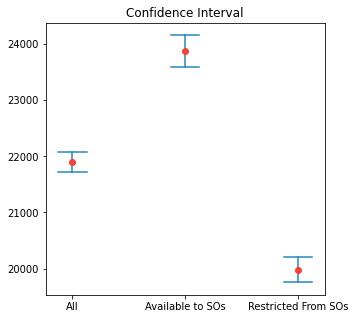

In [90]:
# import matplotlib.pyplot as plt
import statistics
from math import sqrt


def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')

plt.xticks([1, 2, 3], ['All', 'Available to SOs', 'Restricted From SOs'])
plt.title('Confidence Interval')
plot_confidence_interval(1, gdf_parcels.asdtotal)
plot_confidence_interval(2, gdf_res_remain.asdtotal)
plot_confidence_interval(3, gdf_res_restricted.asdtotal)
plt.show()

## Examine some of the outliers

In [32]:
# find a few of the parcels with REALLY high values
highval_parcels = gdf_parcels.loc[gdf_parcels['asdtotal'] > 1000000]
highval_parcels

,handle,asdtotal,ressaleprice,nbrofbldgsres,zoning,geom
13510,11756000305,1049300,0.0,1,B,"POLYGON ((577802.373 1007023.061, 577798.062 1..."
14173,11829000020,1079410,250000.0,1,J,"POLYGON ((576004.055 1016603.581, 575974.595 1..."
36988,13908000330,1416100,0.0,1,E,"POLYGON ((570666.645 1022704.899, 570612.956 1..."
37935,13928000165,3761500,0.0,1,H,"POLYGON ((575140.503 1020422.740, 575139.997 1..."


In [76]:
# plot these high-value parcels on a map so we can see what they are
m_sm = folium.Map([38.636, -90.238], tiles='openstreetmap', zoom_start=17)

folium.GeoJson(
    highval_parcels,
    tooltip=folium.GeoJsonTooltip(
        fields=['handle', 'asdtotal'],
        aliases=['Handle', 'Assessed Total']
    )
).add_to(m_sm)

m_sm

The highest value parcel is Spring Hall on the Saint Louis University Campus

In [55]:
# how common are parcels with multiple residential buildings
print('There are {} parcels with more than one residential building (out of {} total parcels).'.format(
    gdf_parcels.loc[gdf_parcels['nbrofbldgsres'] > 1].shape[0],gdf_parcels.shape[0]))


There are 561 parcels with more than one residential building (out of 98668 total parcels).


In [105]:
def zscore(x,mu,sigma):
    '''Compute the Z-score'''
    if (sigma == 0): # We don't have a "distribution", i.e. there is no variability!
        raise ValueError('Distributions must have non-zero dispersion') 

    return ((x-mu)/sigma)  # This is the equation above
                           # 'x' is the input data value
                           # mu is the distribution mean
                           # sigma is the distribution standard deviation

# End of function


all_mu = gdf_parcels.asdtotal.mean()
all_sigma = gdf_parcels.asdtotal.std()
all_count = len(gdf_parcels.asdtotal)


print('Unrestricted parcel ({}) Z-score vs. All parcels = {}'.format(round(small_mu,1),
        round(zscore(small_mu,all_mu,all_sigma),4)))


# Converted to right-tail
print('norm.cdf(small mu = -2.47) as right-tail p-value for All Parcel distr. --> ', 
          1 - stats.norm.cdf(small_mu,all_mu,all_sigma))

Unrestricted parcel (23873.7) Z-score vs. All parcels = 0.0685
norm.cdf(small mu = -2.47) as right-tail p-value for All Parcel distr. -->  0.47270658739936355


In [14]:
# generate summary info from each dataset
# df1 = pd.Series(gdf_parcels['asdtotal'].describe().apply(lambda x: format(x, 'f')), name = 'all_parcels')
# df2 = pd.Series(gdf_res_remain['asdtotal'].describe().apply(lambda x: format(x, 'f')), name = 'unrestricted_parcels')
df1 = gdf_parcels['asdtotal'].describe()
df2 = gdf_res_remain['asdtotal'].describe()


In [15]:
# combine summaries into a single dataframe with appropriate column names
asd_summary = pd.merge(df1, df2, right_index = True, left_index = True)
asd_summary.columns = ['all_parcels','unrestricted_parcels']
# asd_summary.dtypes

# compute differncees
asd_summary['delta'] = asd_summary['unrestricted_parcels'] - asd_summary['all_parcels']
asd_summary['delta_per'] = asd_summary['delta'] / asd_summary['all_parcels']
# asd_summary.round(2)

# save counts as their own element
asd_summary_count = asd_summary[:1]
asd_summary_count = asd_summary_count.style.format({'delta_per':'{:.2%}'.format})

# drop the non-currency row that we just stored separately
asd_summary = asd_summary.drop(asd_summary.index[[0]])

# format the numbers for a more intuitive presentation
asd_summary.rename(columns = {'all_parcels':'All Parcels','unrestricted_parcels':'Unrestricted Parcels',
                              'delta':'Delta','delta_per':'Delta %'}).style.format({
    'All Parcels': "${:,.0f}".format, 
    'Unrestricted Parcels': "${:,.0f}".format, 
    'Delta': "${:,.0f}".format, 
    'Delta %': '{:.2%}'.format
}).set_table_styles([dict(selector="th",props=[('max-width', '80px'),('text-align', 'center')])])


,All Parcels,Unrestricted Parcels,Delta,Delta %
mean,"$21,896","$23,874","$1,978",9.03%
std,"$28,886","$31,528","$2,643",9.15%
min,$0,$0,$0,nan%
25%,"$4,510","$5,880","$1,370",30.38%
50%,"$16,970","$19,575","$2,605",15.35%
75%,"$30,860","$31,890","$1,030",3.34%
max,"$3,761,500","$3,761,500",$0,0.00%


In [16]:
asd_summary_count

,all_parcels,unrestricted_parcels,delta,delta_per
count,98668.000000,48542.000000,-50126.000000,-50.80%


In [17]:
asd_summary_for_plot = asd_summary.transpose()
asd_summary_for_plot

,mean,std,min,25%,50%,75%,max
all_parcels,21895.933636,28885.866301,0.0,4510.000000,16970.000000,30860.000000,3761500.0
unrestricted_parcels,23873.688146,31528.376221,0.0,5880.000000,19575.000000,31890.000000,3761500.0
delta,1977.754510,2642.509920,0.0,1370.000000,2605.000000,1030.000000,0.0
delta_per,0.090325,0.091481,NaN,0.303769,0.153506,0.033377,0.0


In [26]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from functools import reduce
# import matplotlib as mpl

In [35]:
# remove outliers for gdf_parcels
lowerquantile = 0
upperquantile = 1

Q1_all = gdf_parcels['asdtotal'].quantile(lowerquantile)
Q3_all = gdf_parcels['asdtotal'].quantile(upperquantile)
IQR_all = Q3_all - Q1_all

gdf_parcels_95 = gdf_parcels['asdtotal'][~((gdf_parcels['asdtotal'] > (Q3_all + 1.5 * IQR_all)))]


# remove outliers for gdf_res_remain
Q1_remain = gdf_res_remain['asdtotal'].quantile(lowerquantile)
Q3_remain = gdf_res_remain['asdtotal'].quantile(upperquantile)
IQR_remain = Q3_remain - Q1_remain

gdf_res_remain_95 = gdf_res_remain['asdtotal'][~((gdf_res_remain['asdtotal'] > (Q3_remain + 1.5 * IQR_remain)))]

In [36]:
gdf_parcels_95.describe()

count    9.866800e+04
mean     2.189593e+04
std      2.888587e+04
min      0.000000e+00
25%      4.510000e+03
50%      1.697000e+04
75%      3.086000e+04
max      3.761500e+06
Name: asdtotal, dtype: float64

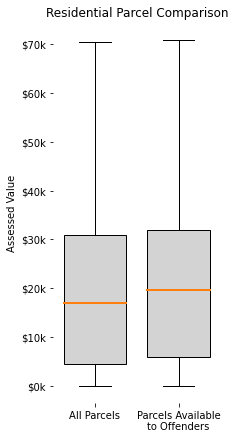

In [39]:
from matplotlib.ticker import FuncFormatter


box_plot_data=[gdf_parcels_95,gdf_res_remain_95]
# plt.boxplot(box_plot_data)

fig, ax = plt.subplots(figsize=(3,7), facecolor='white')


def thousands(x, pos):
    'The two args are the value and tick position'
    return '$%1.fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

ax.yaxis.set_major_formatter(formatter)


plt.boxplot(box_plot_data, patch_artist=True, labels=['All Parcels','Parcels Available\nto Offenders'], 
                showfliers=False, widths = 0.75, boxprops=dict(facecolor='lightgrey'), medianprops=dict(linewidth=2))
plt.gca().set(title='Residential Parcel Comparison', ylabel='Assessed Value')

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

plt.show()


In [40]:
# calculate the difference in means
# show this along with a count of parcels 
# e.g. "55% fewer parcels (living locations) available to them, and what is there costs 17% more"


In [41]:
# gdf_parcels['asdtotal'].mean()
gdf_parcels['asdtotal'].median()

16970.0

In [42]:
# gdf_res_remain['asdtotal'].mean()
gdf_res_remain['asdtotal'].median()

19575.0

In [43]:
asd_summary_for_plot[['mean','50%']]

,mean,50%
all_parcels,21895.933636,16970.000000
unrestricted_parcels,23873.688146,19575.000000
delta,1977.754510,2605.000000
delta_per,0.090325,0.153506


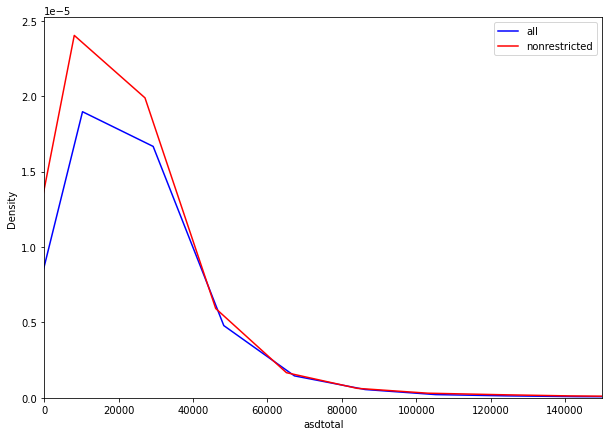

In [44]:
import seaborn as sns

# plot distplot
fig, ax = plt.subplots(figsize=(10,7))
# sns.distplot(data, ax = ax)
sns.kdeplot(gdf_parcels['asdtotal'],  ax=ax, color='blue', label='all')
sns.kdeplot(gdf_res_remain['asdtotal'], ax=ax, color='red', label='nonrestricted')

    
# change the limits of X-axis
ax.set_xlim(0, 150000)
plt.legend()
plt.show()